In [42]:
import evaluation as e
import torch
import distributions as d
import models as m
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import time

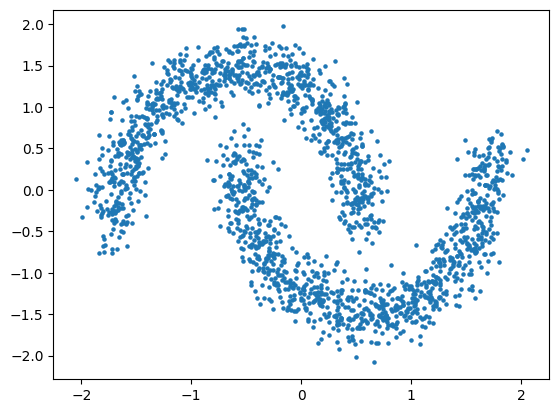

In [28]:
x, _ = make_moons(n_samples=2000, noise=0.1)
scaler = StandardScaler()
x = scaler.fit_transform(x)
plt.scatter(x[:,0], x[:,1], s=5)

# GMM

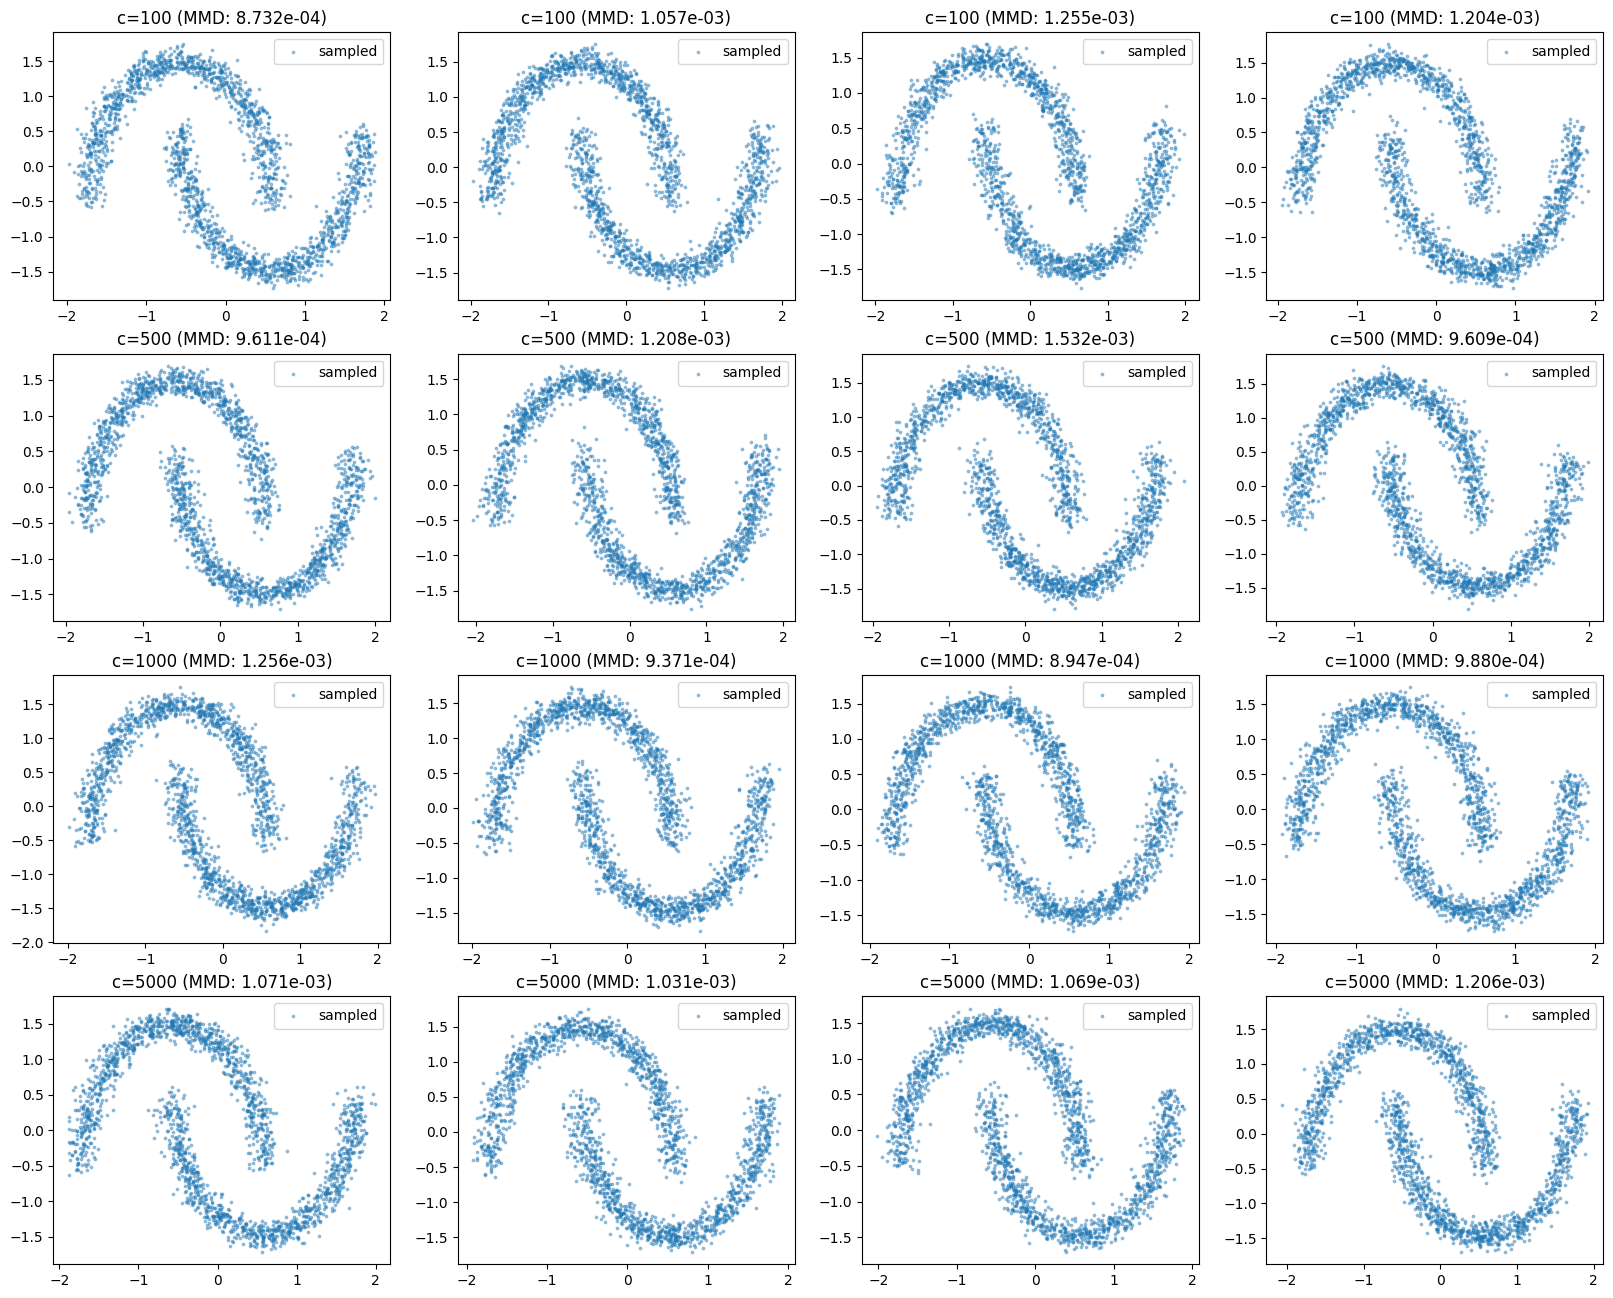

In [47]:
cs = [100, 500, 1000, 5000]
gmm_mmd=[]

fig, axs = plt.subplots(4,4, figsize=(20,16))

for i in range(4):
    for j in range(4):

        gmm = d.moons_gmm(components=cs[i])
        x_gmm = gmm.sample(sample_shape=torch.Size([2000]))
        #axs[i][j].scatter(x[:,0], x[:,1], s=3, alpha=.4, label="true")
        axs[i][j].scatter(x_gmm[:,0], x_gmm[:,1], s=3, alpha=.4, label="sampled")
        axs[i][j].legend()
        
        axs[i][j].set_title(f"c={cs[i]} (MMD: {e.mmd_inverse_multi_quadratic(torch.Tensor(x).float(), torch.Tensor(x_gmm).float()):.3e})")

# KDE

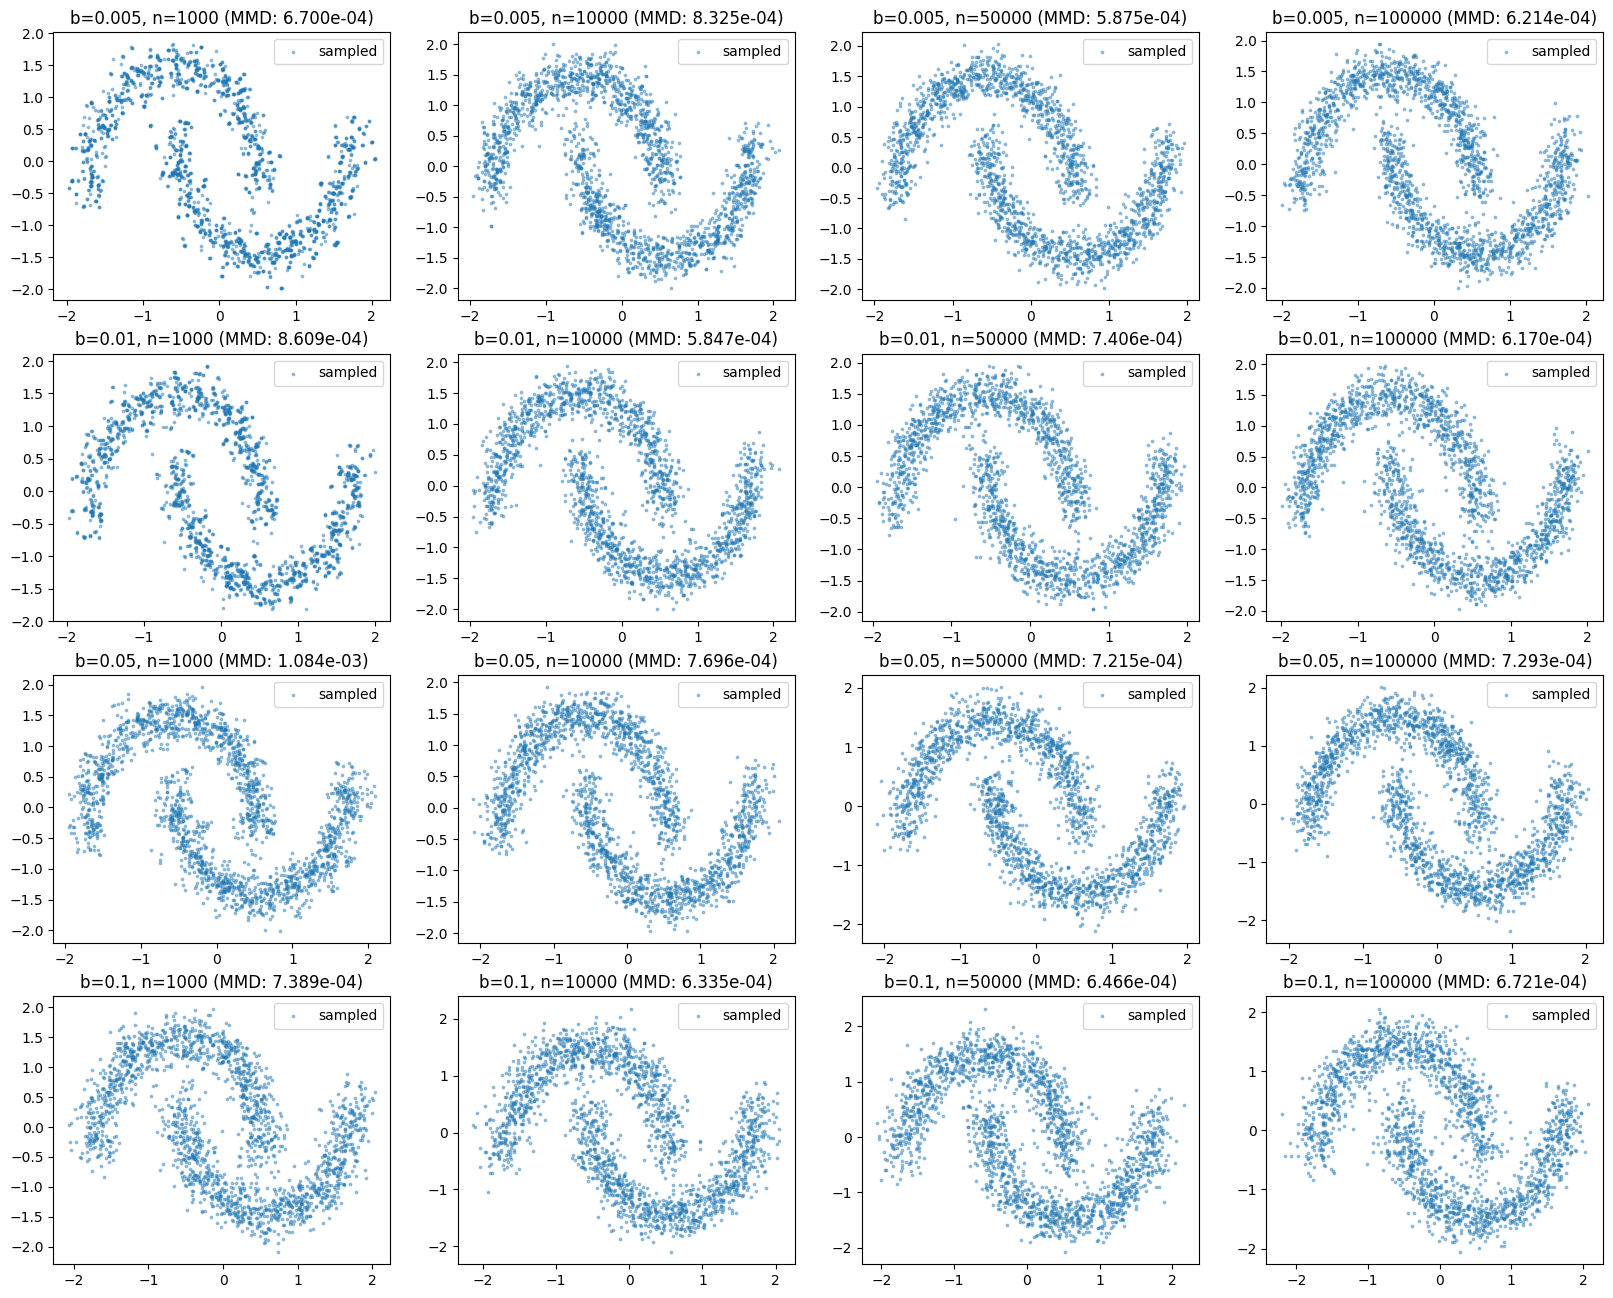

In [46]:
bw = [0.005, 0.01, 0.05, 0.1]
ns = [1000, 10000, 50000, 100000]
kde_mmd=[]

fig, axs = plt.subplots(4,4, figsize=(20,16))

for i in range(4):
    for j in range(4):

        kde = d.moons_distribution(n_samples=ns[j], bandwidth=bw[i])
        x_kde = kde.sample(n_samples=2000)
        #axs[i][j].scatter(x[:,0], x[:,1], s=3, alpha=.4, label="true")
        axs[i][j].scatter(x_kde[:,0], x_kde[:,1], s=3, alpha=.4, label="sampled")
        axs[i][j].legend()
        axs[i][j].set_title(f"b={bw[i]}, n={ns[j]} (MMD: {e.mmd_inverse_multi_quadratic(torch.Tensor(x), torch.Tensor(x_kde)):.3e})")

# INN

In [27]:
subnet_hidden_dim = 20
n_blocks = 32
inn_batchsize = 100
inn_epochs = 4000
inn_lr = 0.0002
subnet_hidden_layers = 2

100%|██████████| 4000/4000 [05:13<00:00, 12.76it/s]


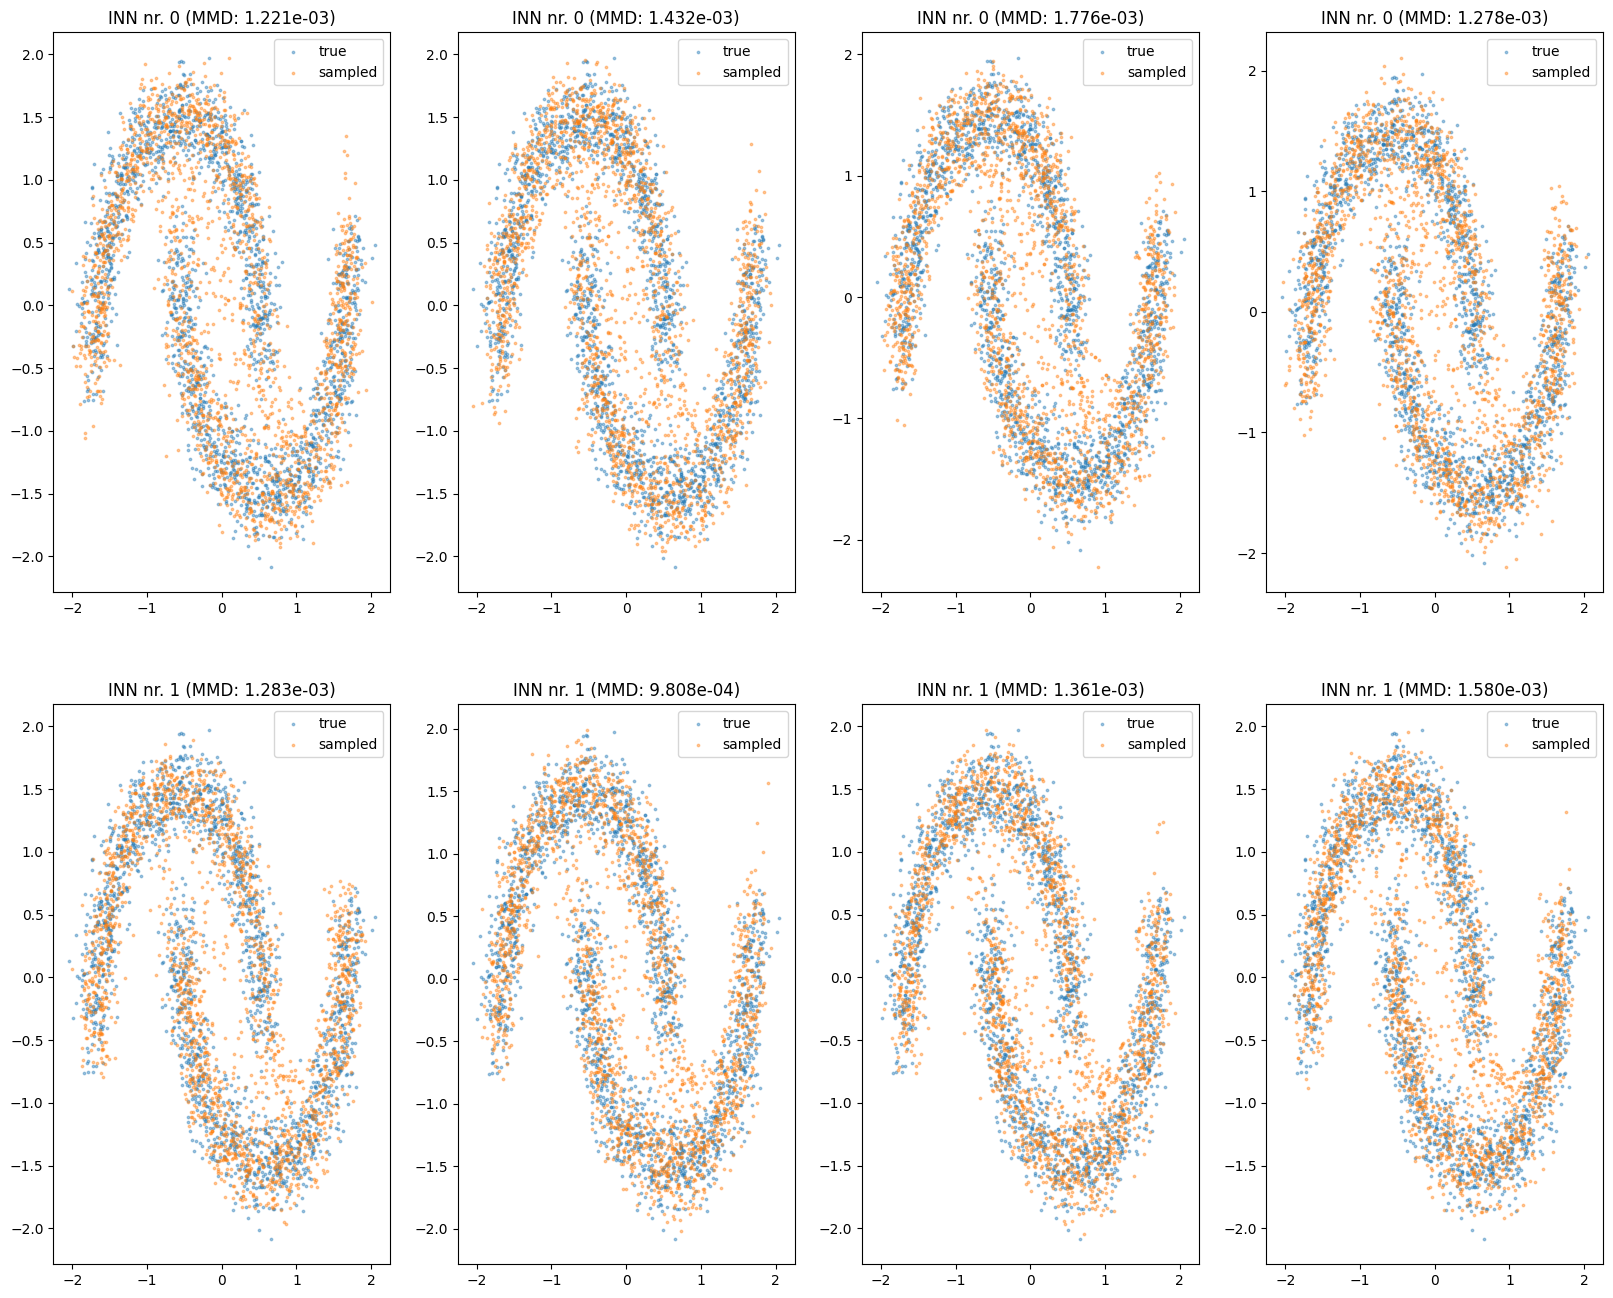

In [34]:
fig, axs = plt.subplots(2,4, figsize=(20,8))

for i in range(2):
    inn = m.realNVP(2, subnet_hidden_dim, n_blocks, subnet_hidden_layers=subnet_hidden_layers)
    inn, inn_metrics, models = m.train_inn(inn, 
                                        batchsize=inn_batchsize, 
                                        epochs=4000, 
                                        lr=inn_lr)
    for j in range(4):
        x_inn = inn.sample(num_samples=2000)
        x_inn = x_inn.detach().numpy()
        axs[i][j].scatter(x[:,0], x[:,1], s=3, alpha=.4, label="true")
        axs[i][j].scatter(x_inn[:,0], x_inn[:,1], s=3, alpha=.4, label="sampled")
        axs[i][j].legend()
        axs[i][j].set_title(f"INN nr. {i} (MMD: {e.mmd_inverse_multi_quadratic(torch.Tensor(x), torch.Tensor(x_inn)):.3e})")

# Comparison of probability distributions and inference times

In [50]:
gmm = d.moons_gmm(components=500)
kde = d.moons_distribution(n_samples=10000, bandwidth=0.01)

grid = torch.stack(torch.meshgrid(torch.linspace(-2., 2., 100), torch.linspace(-2., 2., 100), indexing='xy'))
grid = grid.reshape(2, -1).T

zeit = time.time()
kde_pred = np.exp(kde.score_samples(grid))
print("KDE inference time:", time.time()-zeit)

zeit = time.time()
gmm_pred = np.exp(gmm.log_prob(grid))
print("GMM inference time:", time.time()-zeit)

zeit = time.time()
inn_pred = torch.exp(inn.logprob(grid))
print("INN inference time:", time.time()-zeit)

0.0
KDE inference time: 1.8008232116699219
GMM inference time: 0.2572643756866455
INN inference time: 0.09998869895935059


KDE is most accurate (~6e-4 KLD), but inference time is too long.\
GMM is pretty inaccurate, with faster inference time.\
INN has lowest inference time and has accuracy comparable to KDE (~1e-3 KLD).

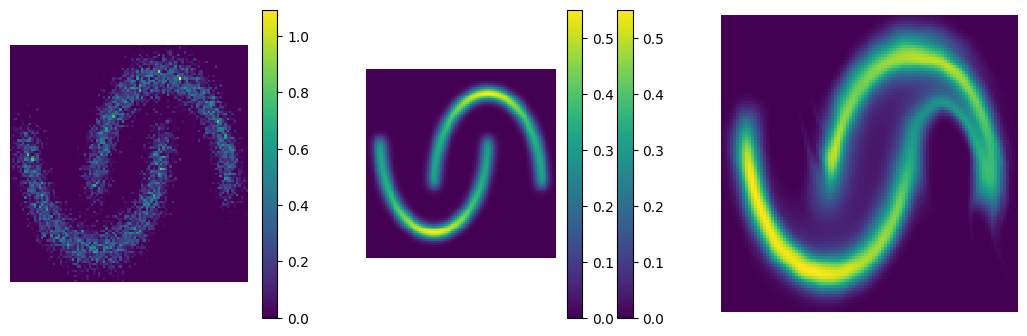

In [52]:
fig, axs = plt.subplots(1,3,figsize=(13,4))
axs = axs.flatten()

cax0 = axs[0].matshow(kde_pred.reshape(100,100))
axs[0].axis("off")
cbar = plt.colorbar(cax0)

cax1 = axs[1].matshow(gmm_pred.reshape(100,100))
axs[1].axis("off")
cbar = plt.colorbar(cax1)

cax2 = axs[2].matshow(inn_pred.detach().numpy().reshape(100,100))
axs[2].axis("off")
cbar = plt.colorbar(cax1)

plt.show()